# Bostrom supply simulation
---

In [1]:
import time
import itertools

# Standard libraries: https://docs.python.org/3/library/
import math

# Analysis and plotting modules
import pandas as pd
import matplotlib.pyplot as plt

# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

from collections import Counter
from cadCAD import configs

# custom functions modules
from utils.partial_state_update_blocks import partial_state_update_blocks
from utils.plots import linear_plot, scatter_plot, df_preparator, plot_line_2_diff_y, plot_line_2_same_y

## Initial state

In [2]:
sim_period = 10           # amount of years for simulating
timesteps_per_year = 365        # units per year(days`

In [3]:
initial_state = {
    'boot_inflation_rate': 0.10,
    'boot_supply': 1_000_000_000_000_000,
    'boot_liquid_supply': 200_000_000_000_000,
    'boot_frozen_supply': 700_000_000_000_000,
    'boot_bonded_supply': 100_000_000_000_000,
    'boot_claimed_supply': 0,
    'boot_to_distribution_supply': 0,
    'hydrogen_supply': 100_000_000_000_000,
    'hydrogen_supply': 0,
    'agents_count': 250,
    'capitalization_per_agent': 1,
    'capitalization_in_eth': 250 * 1,
    'cyberlinks_per_day': 0,
    'validator_revenue_gboot': 0,
    'timestep_provision_boot': 0,
    'gboot_price': 250 * 1 / 1_000_000,
    'cyberlinks_count': 0,
    'ampere_supply': 0,
    'volt_supply': 0,
    'investmint_max_period': math.floor(timesteps_per_year / 4),
    'ampere_mint_rate': 1,
    'volt_mint_rate': 1,
    'gpu_memory_usage': 0,
    'ampere_volt_ratio': 0.5,
    'volt_liquid_supply': 0
}

## Params for simulating

In [4]:
# vesting_speed = [3, 6, 12, 18, 24, 30, 36]
# unvesting_speed = [72, 60, 48, 36, 30, 24]

# parameter_sweep = list(itertools.product(vesting_speed, unvesting_speed))

# vesting_speed = [x[0] for x in parameter_sweep]
# unvesting_speed = [x[1] for x in parameter_sweep]

In [5]:
system_params = {
    # timesteps params
    'timesteps_per_year': [timesteps_per_year], # units per year(days)
    
    # boot inflation params
    'boot_inflation_rate_change_annual': [0.07], # maximum inflation rate change per year
    'boot_inflation_rate_min': [0.05], # minimum percent of the inflation
    'boot_inflation_rate_max': [0.20], # maximum percent of the inflation
    'boot_bonded_share_target': [0.70], # desireable ratio between vested tokens and tokens supply
    
    # boot bonding amount params
    'boot_bonding_share': [0.70],
    
    # gift claim dynamics params
    'days_for_gift_activation': [30],
    'claimed_at_activation_share': [0.85],
    'days_for_gift_full_claim': [150],
    'boot_gift_amount_init': [700_000_000_000_000],
    'liquid_boot_supply_share': [0.25],
    
    # understanding network effects params
    'agents_count_at_activation': [10_000],
    'start_capitalization_per_agent': [1],
    'capitalization_per_agent': [1],
    
    # predicting volts demand params
    'cyberlinks_transactions_coeff': [3],
    'extra_links': [0],
    'guaranted_links': [0],
    
    # amper and volt minting params
    'ampere_base_halving_period': [365 * 3 / 2], # 180 days
    'volt_base_halving_period': [365 * 3 / 2], # 180 days
    'ampere_mint_rate_init': [1], # initial mint rate for Amperes
    'volt_mint_rate_init': [1], # initial mint rate for Voltes
    'ampere_base_investmint_amount': [1_000_000_000], # initial cost for resource token in 1 cycle
    'volt_base_investmint_amount': [1_000_000_000], # initial cost for resource token in 1 cycle
    'ampere_base_investmint_period': [math.floor(timesteps_per_year / 2)], # 3 month
    'volt_base_investmint_period': [math.floor(timesteps_per_year / 2)], # 3 month
    'investmint_max_period_init': [math.floor(timesteps_per_year / 3)], # 4 months
    'horizont_period_init': [math.floor(timesteps_per_year)], # 6 months
    
    # Investments into infrastructure params
    'validator_commission': [0.1],
    'max_validator_count': [92],
}

In [6]:
del configs[:]
experiment = Experiment()

sim_config = config_sim({
    'N': 1,
    'T': range(int(math.ceil(sim_period * timesteps_per_year))),
    'M': system_params
})

experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)

In [7]:
exec_context = ExecutionContext()

simulation = Executor(exec_context=exec_context, configs=configs)
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (3650, 29, 1, 23)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.49s


In [8]:
start_time = time.time()
simulation_result = pd.DataFrame(raw_result)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.03418612480163574 seconds ---


In [9]:
start_time = time.time()

In [10]:
df = simulation_result.copy()

In [11]:
# save local model file for power bi
# import pyarrow as pa
# import pyarrow.parquet as pq
# table = pa.Table.from_pandas(df)
# pq.write_table(table, 'simulation.parquet')

In [12]:
plot_df = df_preparator(df)

In [13]:
plot_df


,boot_inflation_rate,boot_supply,boot_liquid_supply,boot_frozen_supply,boot_bonded_supply,boot_claimed_supply,boot_to_distribution_supply,hydrogen_supply,agents_count,capitalization_per_agent,...,investmint_max_period,ampere_mint_rate,volt_mint_rate,gpu_memory_usage,ampere_volt_ratio,simulation,subset,run,substep,timestep
0,0.100000,1000000000000000,2.000000e+14,7.000000e+14,100000000000000,0.000000e+00,0.000000e+00,0,250,1.000000,...,91.0,1.000000,1.000000,0.000000e+00,0.5,0,0,1,0,0
1,0.100164,1000273972602739,1.995240e+14,7.000000e+14,100750000000000,1.983333e+13,1.983333e+13,750000000000,350,13.226410,...,365.0,1.000000,1.000000,0.000000e+00,0.5,0,0,1,1,1
2,0.100329,1000548470755776,1.990503e+14,7.000000e+14,101498214897260,3.966667e+13,3.966667e+13,1498214897260,468,10.450868,...,365.0,1.000000,1.000000,1.040521e+06,1.0,0,0,1,1,2
3,0.100493,1000823494307804,1.985788e+14,7.000000e+14,102244653356729,5.950000e+13,5.950000e+13,2244653356729,604,8.527621,...,365.0,1.000000,1.000000,1.105724e+06,1.0,0,0,1,1,3
4,0.100656,1001099043109416,1.981097e+14,7.000000e+14,102989324010295,7.933333e+13,7.933333e+13,2989324010295,758,7.133032,...,365.0,1.000000,1.000000,1.185633e+06,1.0,0,0,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,0.050000,2114135024058567,7.452799e+13,0.000000e+00,2040307030797418,7.000000e+14,1.974230e-146,1940307030797418,119971880,0.001396,...,5840.0,0.015625,0.015625,7.423839e+11,1.0,0,0,1,1,3646
3647,0.050000,2114424631596109,7.453812e+13,0.000000e+00,2040586510772147,7.000000e+14,1.776807e-146,1940586510772147,120037608,0.001395,...,5840.0,0.015625,0.015625,7.428721e+11,1.0,0,0,1,1,3647
3648,0.050000,2114714278805916,7.454825e+13,0.000000e+00,2040866028725236,7.000000e+14,1.599126e-146,1940866028725236,120103354,0.001395,...,5840.0,0.015625,0.015625,7.433605e+11,1.0,0,0,1,1,3648
3649,0.050000,2115003965693423,7.455838e+13,0.000000e+00,2041145584663038,7.000000e+14,1.439214e-146,1941145584663038,120169118,0.001394,...,5840.0,0.015625,0.015625,7.438491e+11,1.0,0,0,1,1,3649


## Boot suplly and inflation

<AxesSubplot:label='0f2d3640-2e98-4b00-865d-b13fb4fa22a3'>

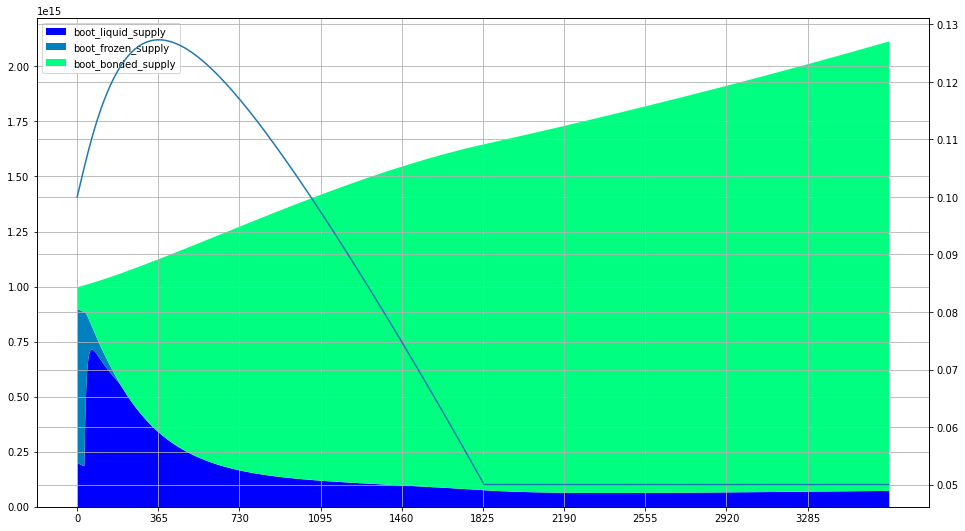

In [14]:
columns = ['boot_liquid_supply', 'boot_frozen_supply', 'boot_bonded_supply']
supply_df = plot_df[columns]
boot_inflation_df = plot_df['boot_inflation_rate']

ax1 = supply_df.plot.area(linewidth=0, colormap="winter", xticks=range(0, 3650, 365), grid=True)

ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
boot_inflation_df.plot.line(ax=ax2, figsize=(16,9), style={'boot_inflation': 'y'}, xticks=range(0, 3650, 365), grid=True)

<AxesSubplot:>

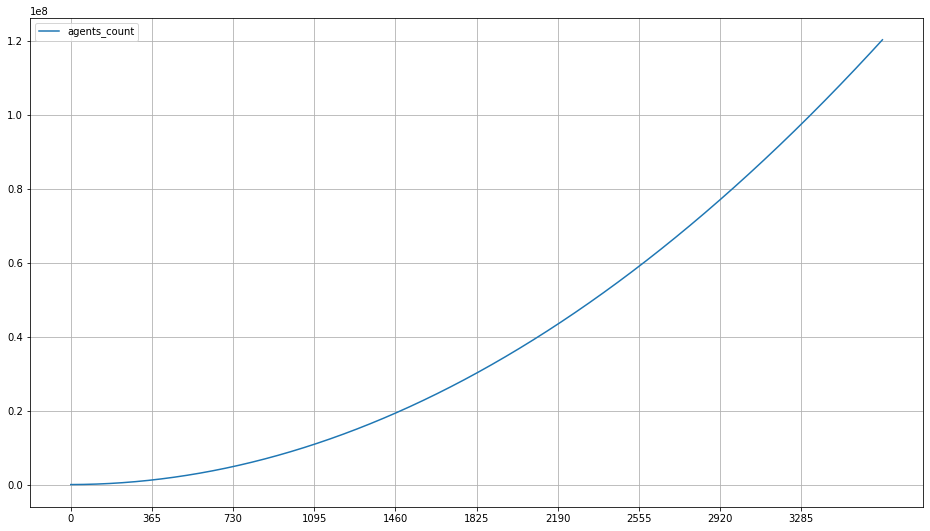

In [15]:
plot_df.plot(y='agents_count', figsize=(16, 9), xticks=range(0, 3650, 365), grid=True)

<AxesSubplot:>

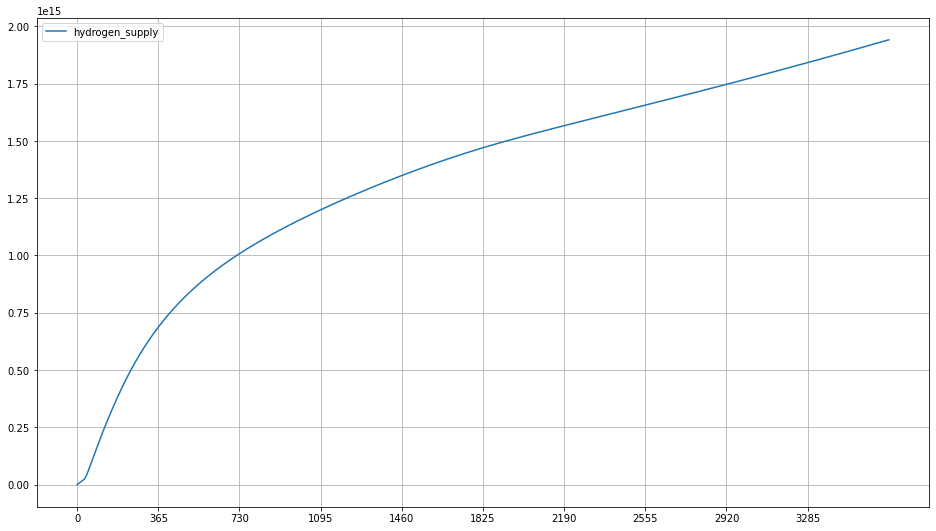

In [16]:
plot_df.plot(y='volt_liquid_supply', figsize=(16, 9), xticks=range(0, 3650, 365), grid=True)

In [ ]:
plot_df.plot(y='hydrogen_supply', figsize=(16, 9), xticks=range(0, 3650, 365), grid=True)

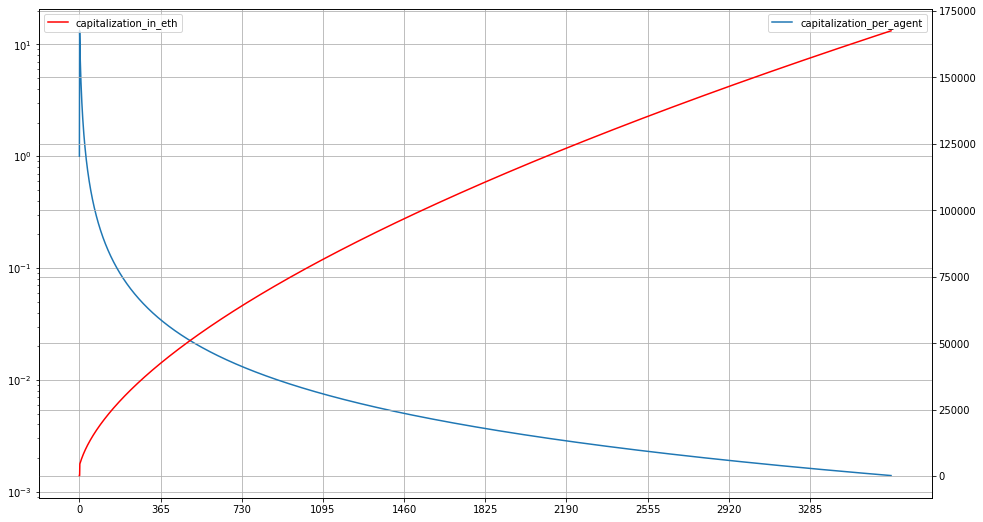

In [17]:
# agents_count.plot.line(figsize=(16,9), logy=True, xticks=range(0, 3650, 365))
plot_line_2_diff_y(plot_df, 'capitalization_per_agent', 'capitalization_in_eth', value_1_log=True)

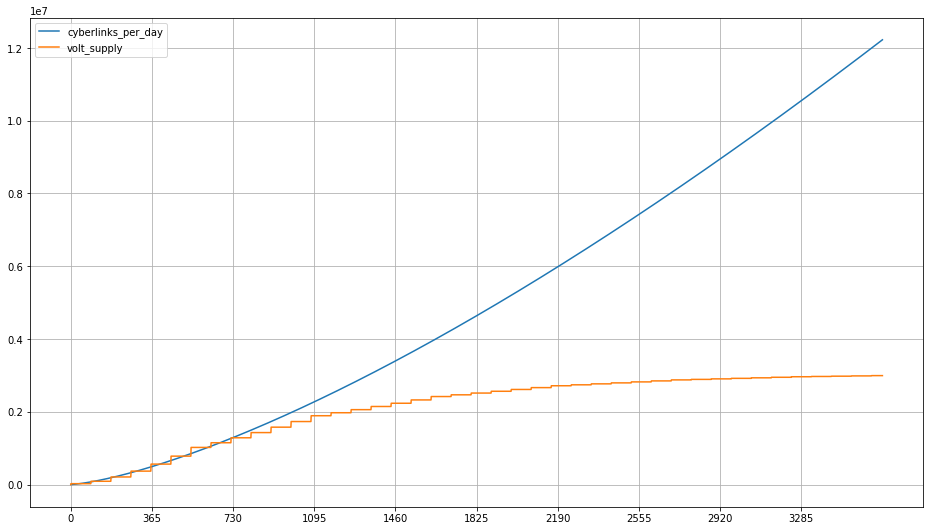

In [18]:
plot_line_2_same_y(plot_df, ['cyberlinks_per_day', 'volt_supply'])
# ax1 = df.plot(y=['delta_cyberlinks', 'minted_volt_amount'], figsize=(16, 9), xticks=range(0, 3650, 365), grid=True)
# ax2 = ax1.twinx()
# ax2.spines['right'].set_position(('axes', 1.0))
# plot_df.plot.line(ax=ax2, y='cyberlinks', figsize=(16, 9), xticks=range(0, 3650, 365), style={'cyberlinks': 'r'}, grid=True)


<AxesSubplot:xlabel='timestep'>

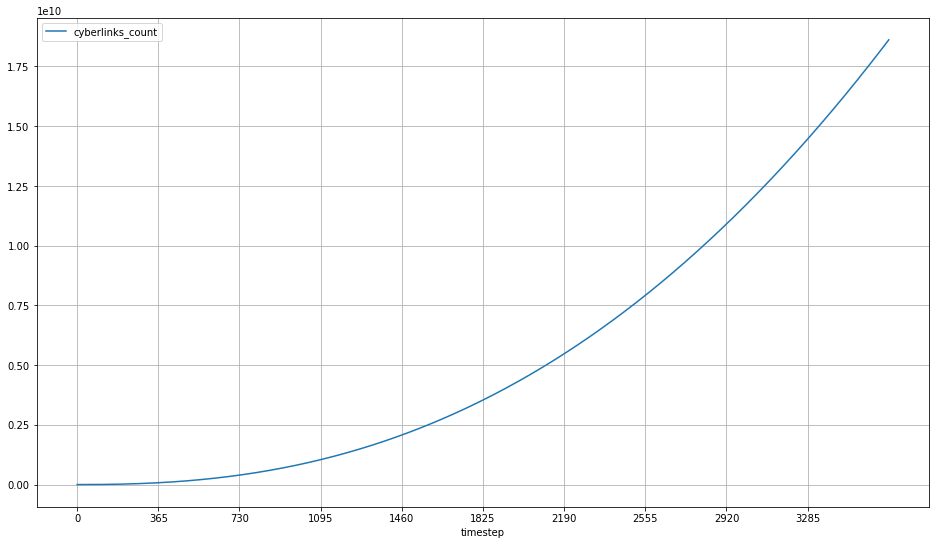

In [19]:
plot_df.plot.line(x='timestep', y='cyberlinks_count', grid=True, xticks=range(0, 3650, 365), figsize=(16, 9))

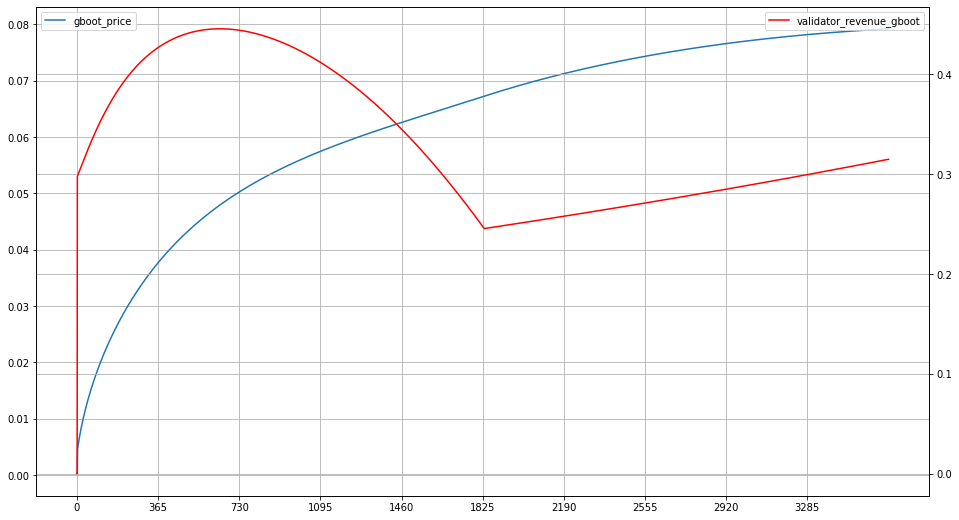

In [20]:
plot_line_2_diff_y(plot_df, 'gboot_price', 'validator_revenue_gboot')

<AxesSubplot:label='353a41aa-95dc-4962-852e-22c87fd11b98'>

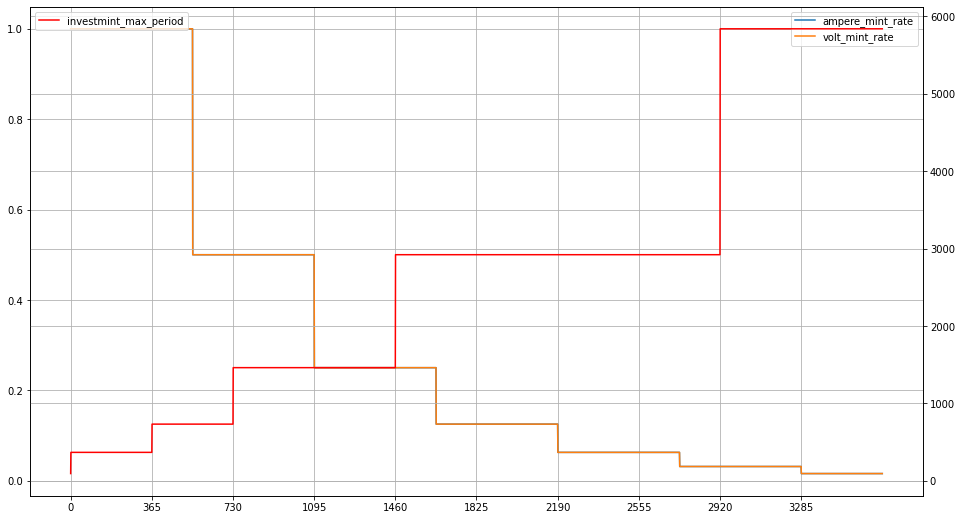

In [21]:
ax1 = df.plot(y=['ampere_mint_rate', 'volt_mint_rate'], figsize=(16, 9), xticks=range(0, 3650, 365), grid=True)
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
plot_df.plot.line(ax=ax2, y='investmint_max_period', figsize=(16, 9), xticks=range(0, 3650, 365), style={'investmint_max_period': 'r'}, grid=True)

<AxesSubplot:label='a7f3b974-76d6-476d-9c62-2efafcd21628'>

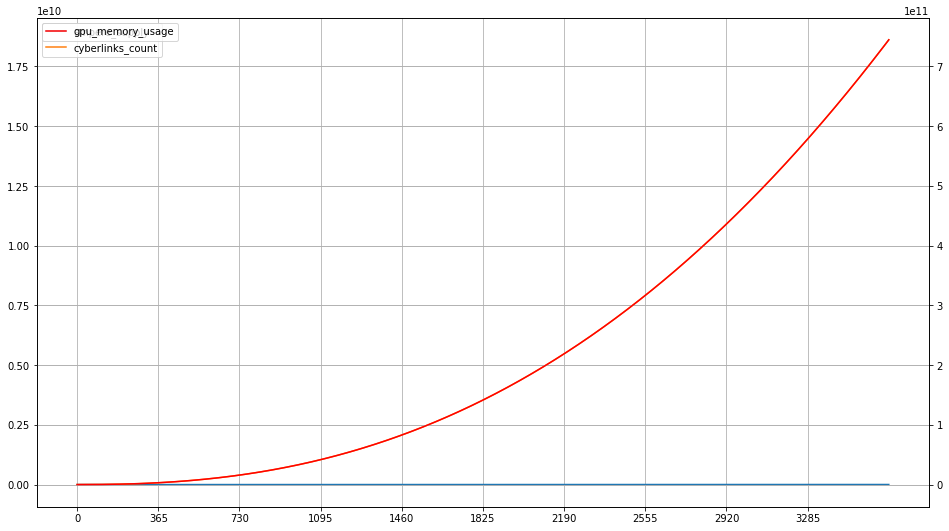

In [22]:
ax1 = df.plot(y=['ampere_supply', 'cyberlinks_count'], figsize=(16, 9), xticks=range(0, 3650, 365), grid=True)
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
plot_df.plot.line(ax=ax2, y='gpu_memory_usage', figsize=(16, 9), xticks=range(0, 3650, 365), style={'gpu_memory_usage': 'r'}, grid=True)

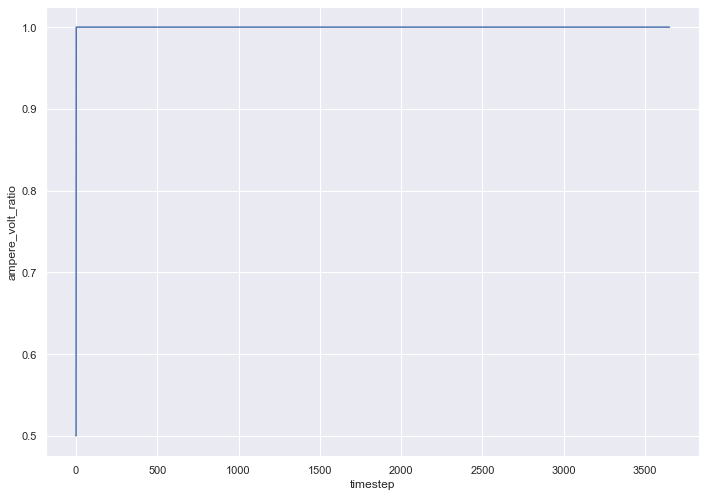

In [23]:
linear_plot(plot_df, 'ampere_volt_ratio', render='sns')

In [24]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 16.83471918106079 seconds ---
